## Sistemática - Trading Strategies

##### By: Nicolás Florián Ortiz, Juan Esteban Garzón Borda, Juan Diego Gutierrez Ortiz 

In [70]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, plot_heatmaps
import matplotlib.pyplot as plt
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')

### 1. Funciones de estrategias individuales

 #### 1.1 DMI + ADX

In [71]:
def DMI_ADX_Strategy(data, N):

    # Creo listas vacías para guardar los valores de DM+ y DM-
    DM_p_values = []
    DM_n_values = []

    for i in range(1, len(data)):
        a1 = data.iloc[i]['High'] - data.iloc[i-1]['High']
        a2 = data.iloc[i-1]['Low'] - data.iloc[i]['Low']
        if a1 > a2:
            DM_p = max(0, a1)
            DM_n = 0
        else:
            DM_p = 0
            DM_n = max(0, a2)
            
        DM_p_values.append(DM_p)
        DM_n_values.append(DM_n)

    # Guardo los DM+ y DM- en la lista vacía
    data['DM+'] = [0] + DM_p_values
    data['DM-'] = [0] + DM_n_values

    # Lista vacía para los true range
    True_range_values = []
    for i in range(1, len(data)):

        # True Range
        True_range = max(data.iloc[i]['High'], data.iloc[i-1]['Adj Close']) - min(data.iloc[i]['Low'], data.iloc[i-1]['Adj Close'])
        True_range_values.append(True_range)

    data['True Range'] = [0] + True_range_values
    data['ATR'] = data['True Range'].ewm(span=N, min_periods=N).mean()

    # Se suavizan los DM+ y DM-
    data['WSMA_DM+'] = data['DM+'].rolling(window=N).mean()
    data['WSMA_DM-'] = data['DM-'].rolling(window=N).mean()

    # Se calculan los DMI+ y DMI-
    data['DMI+'] = (data['WSMA_DM+']/data['ATR'])*100
    data['DMI-'] = (data['DM-'].ewm(span=N, min_periods=N).mean())*100

    # Se calcula el ADX y el DX
    data['DX'] = np.abs(data['DMI+'] - data['DMI-']) / (data['DMI+'] + data['DMI-']) * 100
    data['ADX'] = data['DX'].ewm(span=N, min_periods=N).mean()

    data['Long_Position'] = [1 if (data.iloc[i]['DMI+'] > data.iloc[i]['DMI-'] and data.iloc[i]['ADX'] > 25) else 0 for i in range(len(data))]
    data['Short_Position'] = [1 if (data.iloc[i]['DMI+'] < data.iloc[i]['DMI-'] and data.iloc[i]['ADX'] > 25) else 0 for i in range(len(data))]

    # Inicialización de alarmas de posiciones largas
    data['Long_Position'] = 0
    for i in range(1, len(data)):
        if data['DMI+'].iloc[i] > data['DMI-'].iloc[i] and data['ADX'].iloc[i] > 25  and data['Long_Position'].iloc[i-1] == 0 and data['Long_Position'].iloc[i-2] == 0:
            data.loc[data.index[i], 'Long_Position'] = 1 
            
    data['Cumplimiento'] = 0
    for i in range(1, len(data)):
        if data['Long_Position'].iloc[i-1] == 1 and data['Close'].iloc[i] > data['Close'].iloc[i-1]:
            data.loc[data.index[i],'Cumplimiento'] = 1

    # Inicialización de alarmas de posiciones cortas
    data['Short_Position'] = 0
    for i in range(1, len(data)):
        if data['DMI+'].iloc[i] < data['DMI-'].iloc[i] and data['ADX'].iloc[i] > 25 :
            data.loc[data.index[i], 'Short_Position'] = 1
    data['Cumplimiento_Short'] = 0
    for i in range(1, len(data)):
        if data['Short_Position'].iloc[i-2] == 1 and data['Close'].iloc[i] < data['Close'].iloc[i-2]:
            data.loc[data.index[i],'Cumplimiento_Short'] = 1
    
    tasa_aprobacion = (data['Cumplimiento'].sum()+data['Cumplimiento_Short'].sum()) /(data['Long_Position'].sum() + data['Short_Position'].sum())

    return tasa_aprobacion





 #### 1.2 Bandas de Bollinger

In [72]:
import pandas as pd
import numpy as np

def Bollinger_Bands_Strategy(data, N):
    # Calcula la Media Móvil y las Bandas de Bollinger
    data['BollMA'] = data['Close'].rolling(window=N).mean()
    data['UpperBand'] = data['BollMA'] + 2 * data['Close'].rolling(window=N).std()
    data['LowerBand'] = data['BollMA'] - 2 * data['Close'].rolling(window=N).std()

    # Inicialización de listas para posiciones y cumplimientos
    data['Long_Position'] = 0
    data['Short_Position'] = 0
    data['Cumplimiento'] = 0
    data['Cumplimiento_Short'] = 0

    # Evaluación de condiciones para entrar en posiciones largas
    for i in range(2, len(data)):
        if data['Close'].iloc[i] < data['LowerBand'].iloc[i] and data['Long_Position'].iloc[i-1] == 0 and data['Long_Position'].iloc[i-2] == 0:
            data.loc[data.index[i], 'Long_Position'] = 1
            if i+1 < len(data) and data['Close'].iloc[i+1] > data['Close'].iloc[i]:
                data.loc[data.index[i+1], 'Cumplimiento'] = 1

    # Evaluación de condiciones para entrar en posiciones cortas
    for i in range(2, len(data)):
        if data['Close'].iloc[i] > data['UpperBand'].iloc[i] and data['Short_Position'].iloc[i-1] == 0 and data['Short_Position'].iloc[i-2] == 0:
            data.loc[data.index[i], 'Short_Position'] = 1
            if i+1 < len(data) and data['Close'].iloc[i+1] < data['Close'].iloc[i]:
                data.loc[data.index[i+1], 'Cumplimiento_Short'] = 1

    # Calcula la tasa de aprobación
    total_long_positions = data['Long_Position'].sum()
    total_short_positions = data['Short_Position'].sum()
    total_positions = total_long_positions + total_short_positions
    total_compliance = data['Cumplimiento'].sum() + data['Cumplimiento_Short'].sum()
    approval_rate = total_compliance / total_positions if total_positions > 0 else 0

    return approval_rate




 #### 1.3 Cruce de Medias

In [73]:
def Moving_Average_Crossover_Strategy(data, short_window, long_window):
    
    data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
    data['Long_MA'] = data['Close'].rolling(window=long_window).mean()

    # Inicialización de listas para posiciones y cumplimientos
    data['Long_Position'] = 0
    data['Short_Position'] = 0
    data['Cumplimiento'] = 0
    data['Cumplimiento_Short'] = 0

    # Detecta cruces para entrar en posiciones largas o cortas
    for i in range(1, len(data)):
        if data['Short_MA'].iloc[i] > data['Long_MA'].iloc[i] and data['Short_MA'].iloc[i-1] < data['Long_MA'].iloc[i-1]:
            data.loc[data.index[i], 'Long_Position'] = 1
            if i+1 < len(data) and data['Close'].iloc[i+1] > data['Close'].iloc[i]:
                data.loc[data.index[i+1], 'Cumplimiento'] = 1
        elif data['Short_MA'].iloc[i] < data['Long_MA'].iloc[i] and data['Short_MA'].iloc[i-1] > data['Long_MA'].iloc[i-1]:
            data.loc[data.index[i], 'Short_Position'] = 1
            if i+1 < len(data) and data['Close'].iloc[i+1] < data['Close'].iloc[i]:
                data.loc[data.index[i+1], 'Cumplimiento_Short'] = 1

    # Calcula la tasa de aprobación
    total_long_positions = data['Long_Position'].sum()
    total_short_positions = data['Short_Position'].sum()
    total_positions = total_long_positions + total_short_positions
    total_compliance = data['Cumplimiento'].sum() + data['Cumplimiento_Short'].sum()
    approval_rate = total_compliance / total_positions if total_positions > 0 else 0

    return approval_rate




#### 1.4. MACD

In [74]:
def MACD_Strategy(data):
    # Cálculo de MACD y la línea de señal
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Inicialización de posiciones y cumplimientos
    data['Long_Position'] = 0
    data['Short_Position'] = 0
    data['Cumplimiento'] = 0
    data['Cumplimiento_Short'] = 0

    # Detecta cruces para entrar en posiciones largas o cortas
    for i in range(1, len(data)):
        if data['MACD'].iloc[i] > data['Signal_Line'].iloc[i] and data['MACD'].iloc[i-1] < data['Signal_Line'].iloc[i-1]:
            data.loc[data.index[i], 'Long_Position'] = 1
            if i+1 < len(data) and data['Close'].iloc[i+1] > data['Close'].iloc[i]:
                data.loc[data.index[i+1], 'Cumplimiento'] = 1
        elif data['MACD'].iloc[i] < data['Signal_Line'].iloc[i] and data['MACD'].iloc[i-1] > data['Signal_Line'].iloc[i-1]:
            data.loc[data.index[i], 'Short_Position'] = 1
            if i+1 < len(data) and data['Close'].iloc[i+1] < data['Close'].iloc[i]:
                data.loc[data.index[i+1], 'Cumplimiento_Short'] = 1

    # Calcula la tasa de aprobación
    total_long_positions = data['Long_Position'].sum()
    total_short_positions = data['Short_Position'].sum()
    total_positions = total_long_positions + total_short_positions
    total_compliance = data['Cumplimiento'].sum() + data['Cumplimiento_Short'].sum()
    approval_rate = total_compliance / total_positions if total_positions > 0 else 0

    return approval_rate

#### 1.5 RSI

In [75]:
def RSI_Strategy(data, period=14):
    # Calcula las ganancias y pérdidas diarias
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    # Calcula la media de las ganancias y pérdidas
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    # Calcula el RSI
    RS = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + RS))

    # Inicialización de posiciones y cumplimientos
    data['Long_Position'] = 0
    data['Short_Position'] = 0
    data['Cumplimiento'] = 0
    data['Cumplimiento_Short'] = 0

    # Detecta condiciones de sobreventa y sobrecompra para entrar en posiciones
    for i in range(1, len(data)):
        if data['RSI'].iloc[i] < 30 and data['RSI'].iloc[i-1] >= 30:
            data.loc[data.index[i], 'Long_Position'] = 1
            if i+1 < len(data) and data['Close'].iloc[i+1] > data['Close'].iloc[i]:
                data.loc[data.index[i+1], 'Cumplimiento'] = 1
        elif data['RSI'].iloc[i] > 70 and data['RSI'].iloc[i-1] <= 70:
            data.loc[data.index[i], 'Short_Position'] = 1
            if i+1 < len(data) and data['Close'].iloc[i+1] < data['Close'].iloc[i]:
                data.loc[data.index[i+1], 'Cumplimiento_Short'] = 1

    # Calcula la tasa de aprobación
    total_long_positions = data['Long_Position'].sum()
    total_short_positions = data['Short_Position'].sum()
    total_positions = total_long_positions + total_short_positions
    total_compliance = data['Cumplimiento'].sum() + data['Cumplimiento_Short'].sum()
    approval_rate = total_compliance / total_positions if total_positions > 0 else 0

    return approval_rate


### 3. Combinación de estrategias

#### 3.1 DMI + Bollinger Bands 

In [76]:
def Backtesting(data, N):
    # Inicializar listas para almacenar los valores de DM+ y DM-
    DM_p_values = []
    DM_n_values = []

    # Calcular los valores de DM+ y DM- para cada fila del DataFrame
    for i in range(1, len(data)):
        a1 = data.iloc[i]['High'] - data.iloc[i-1]['High']  # Máximo de hoy - Máximo de ayer
        a2 = data.iloc[i-1]['Low'] - data.iloc[i]['Low']  # Mínimo de ayer - Mínimo de hoy

        if a1 > a2:
            DM_p = max(0, a1)
            DM_n = 0
        else:
            DM_p = 0
            DM_n = max(0, a2)

        # Agregar los valores calculados a las listas
        DM_p_values.append(DM_p)
        DM_n_values.append(DM_n)

    # Agregar las listas como nuevas columnas al DataFrame
    data['DM+'] = [0] + DM_p_values  # Añadir un 0 al inicio para que tenga la misma longitud que el DataFrame original
    data['DM-'] = [0] + DM_n_values  # Añadir un 0 al inicio para que tenga la misma longitud que el DataFrame original

    # Matriz vacía para cada uno de los true ranges
    True_range_values = []
    # Calcular los valores del True Range para cada fila de datos
    for i in range(1, len(data)):
        # True Range
        True_range = max(data.iloc[i]['High'], data.iloc[i-1]['Adj Close']) - min(data.iloc[i]['Low'], data.iloc[i-1]['Adj Close'])
        True_range_values.append(True_range)

    # Se agregan
    data['True Range'] = [0] + True_range_values
    data['ATR'] = data['True Range'].ewm(span=N, min_periods=N).mean()
    data['WSMA_DM+'] = data['DM+'].rolling(window=N).mean()
    data['WSMA_DM-'] = data['DM-'].rolling(window=N).mean()
    data['DMI+'] = (data['WSMA_DM+'] / data['ATR']) * 100
    data['DMI-'] = (data['DM-'].ewm(span=N, min_periods=N).mean()) * 100

    data['DX'] = np.abs(data['DMI+'] - data['DMI-']) / (data['DMI+'] + data['DMI-']) * 100
    data['ADX'] = data['DX'].ewm(span=N, min_periods=N).mean()

    # Bollinger Bands
    data['BollMA'] = data['Close'].rolling(window=14).mean()
    data['UpperBand'] = data['BollMA'] + 2 * data['Close'].rolling(window=14).std()
    data['LowerBand'] = data['BollMA'] - 2 * data['Close'].rolling(window=14).std()



    data['Long_Position'] = 0
    for i in range(1, len(data)):
        if data['DMI+'].iloc[i] > data['DMI-'].iloc[i] and data['ADX'].iloc[i] > 25 and (
                data['Close'].iloc[i] < data['LowerBand'].iloc[i] or abs(
                data['Close'].iloc[i] - data['LowerBand'].iloc[i]) < 0.05) and data['Long_Position'].iloc[i - 1] == 0 and data['Long_Position'].iloc[i - 2] == 0:
            data.loc[data.index[i], 'Long_Position'] = 1
    data['Cumplimiento'] = 0
    for i in range(1, len(data)):
        if data['Long_Position'].iloc[i - 1] == 1 and data['Close'].iloc[i] > data['Close'].iloc[i - 1]:
            data.loc[data.index[i], 'Cumplimiento'] = 1

    data['Short_Position'] = 0
    for i in range(1, len(data)):
        if data['DMI+'].iloc[i] < data['DMI-'].iloc[i] and data['ADX'].iloc[i] > 25 and (
                data['Close'].iloc[i] > data['UpperBand'].iloc[i] or abs(
                data['Close'].iloc[i] - data['UpperBand'].iloc[i]) <= 0.4) and data['Short_Position'].iloc[i - 1] == 0 and data['Short_Position'].iloc[i - 2] == 0:
            data.loc[data.index[i], 'Short_Position'] = 1
    data['Cumplimiento_Short'] = 0
    for i in range(1, len(data)):
        if data['Short_Position'].iloc[i - 2] == 1 and data['Close'].iloc[i] < data['Close'].iloc[i - 2]:
            data.loc[data.index[i], 'Cumplimiento_Short'] = 1

    tasa_aprobacion = (data['Cumplimiento'].sum() + data['Cumplimiento_Short'].sum()) / (
            data['Long_Position'].sum() + data['Short_Position'].sum())

    # Net Worth
    data['Worth'] = 1000000  # Inicializar Worth con el valor inicial del portafolio

    # Crear listas para precios de entrada y salida
    entry_prices = []
    exit_prices = []
    positions = []

    for i in range(1, len(data)):
        if data['Long_Position'].iloc[i - 1] == 1:
            entry_price = data['Close'].iloc[i - 1]
            max_price = data['Close'].iloc[i]
            j = i
            # Extender posición mientras el precio siga subiendo
            while j + 1 < len(data) and data['Close'].iloc[j + 1] > max_price:
                max_price = data['Close'].iloc[j + 1]
                j += 1
            exit_price = max_price
            data.at[data.index[i], 'Worth'] *= (exit_price / entry_price)  # Cierre de posición
            entry_prices.append(entry_price)
            exit_prices.append(exit_price)
            positions.append('Long')

        elif data['Short_Position'].iloc[i - 2] == 1:
            entry_price = data['Close'].iloc[i - 2]
            min_price = data['Close'].iloc[i]
            j = i
            # Extender posición mientras el precio siga bajando
            while j + 1 < len(data) and data['Close'].iloc[j + 1] < min_price:
                min_price = data['Close'].iloc[j + 1]
                j += 1
            exit_price = min_price
            data.at[data.index[i], 'Worth'] *= (entry_price / exit_price)  # Cierre de la posición con el último precio más bajo encontrado
            entry_prices.append(entry_price)
            exit_prices.append(exit_price)
            positions.append('Short')

        else:
            data.at[data.index[i], 'Worth'] = data['Worth'].iloc[i - 1]  # Mantener el valor anterior si no hay posición abierta

    retorno_final = float(data['Worth'].iloc[-1])

    # Crear DataFrame con precios de entrada y salida
    positions_df = pd.DataFrame({
        "Position Type": positions,
        "Entry Price": entry_prices,
        "Exit Price": exit_prices,
        "Profit/Loss": [exit - entry if pos == 'Long' else entry - exit for pos, entry, exit in zip(positions, entry_prices, exit_prices)]
    })

    # Resumen
    num_longs = data['Long_Position'].sum()
    num_shorts = data['Short_Position'].sum()
    tasa_aprobacion = tasa_aprobacion
    valor_inicial = 1000000
    retorno_final = retorno_final
    cumplimiento_largos = data['Cumplimiento'].sum() / data['Long_Position'].sum()
    cumplimiento_cortos = data['Cumplimiento_Short'].sum() / data['Short_Position'].sum()
    inicio = data.index[0]
    fin = data.index[-1]
    data['Returns'] = data['Close'].pct_change()
    volatilidad = data['Returns'].std() * np.sqrt(252)

    resultados_df = pd.DataFrame({
        "Fecha inicial": [inicio],
        "Fecha final": [fin],
        "Valor Inicial": [valor_inicial],
        "Retorno Final": ['{:f}'.format(retorno_final)],
        "Retorno (%)": [((retorno_final / valor_inicial) - 1) * 100],
        "Tasa de éxito de la estrategia": [tasa_aprobacion],
        "Número de Posiciones Largas": [num_longs],
        "Número de Posiciones Cortas": [num_shorts],
        "Win Rate Largos": [cumplimiento_largos],
        "Win Rate Cortos": [cumplimiento_cortos],
        "Volatilidad": [volatilidad] })

    return resultados_df.T, positions_df

#### 3.2 DMI + Bollinger Bands + MACD

In [77]:
def Backtesting_MACD(data, N):
    # Inicializar listas para almacenar los valores de DM+ y DM-
    DM_p_values = []
    DM_n_values = []

    # Calcular los valores de DM+ y DM- para cada fila del DataFrame
    for i in range(1, len(data)):
        a1 = data.iloc[i]['High'] - data.iloc[i-1]['High']  # Máximo de hoy - Máximo de ayer
        a2 = data.iloc[i-1]['Low'] - data.iloc[i]['Low']  # Mínimo de ayer - Mínimo de hoy

        if a1 > a2:
            DM_p = max(0, a1)
            DM_n = 0
        else:
            DM_p = 0
            DM_n = max(0, a2)

        # Agregar los valores calculados a las listas
        DM_p_values.append(DM_p)
        DM_n_values.append(DM_n)

    # Agregar las listas como nuevas columnas al DataFrame
    data['DM+'] = [0] + DM_p_values  # Añadir un 0 al inicio para que tenga la misma longitud que el DataFrame original
    data['DM-'] = [0] + DM_n_values  # Añadir un 0 al inicio para que tenga la misma longitud que el DataFrame original

    # Matriz vacía para cada uno de los true ranges
    True_range_values = []
    # Calcular los valores del True Range para cada fila de datos
    for i in range(1, len(data)):
        # True Range
        True_range = max(data.iloc[i]['High'], data.iloc[i-1]['Adj Close']) - min(data.iloc[i]['Low'], data.iloc[i-1]['Adj Close'])
        True_range_values.append(True_range)

    # Se agregan
    data['True Range'] = [0] + True_range_values
    data['ATR'] = data['True Range'].ewm(span=N, min_periods=N).mean()
    data['WSMA_DM+'] = data['DM+'].rolling(window=N).mean()
    data['WSMA_DM-'] = data['DM-'].rolling(window=N).mean()
    data['DMI+'] = (data['WSMA_DM+'] / data['ATR']) * 100
    data['DMI-'] = (data['DM-'].ewm(span=N, min_periods=N).mean()) * 100

    data['DX'] = np.abs(data['DMI+'] - data['DMI-']) / (data['DMI+'] + data['DMI-']) * 100
    data['ADX'] = data['DX'].ewm(span=N, min_periods=N).mean()

    # Bollinger Bands
    data['BollMA'] = data['Close'].rolling(window=14).mean()
    data['UpperBand'] = data['BollMA'] + 2 * data['Close'].rolling(window=14).std()
    data['LowerBand'] = data['BollMA'] - 2 * data['Close'].rolling(window=14).std()

    # MACD
    data['EMA_12'] = data['Close'].ewm(span=20, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=30, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()


    data['Long_Position'] = 0
    for i in range(1, len(data)):
        if data['DMI+'].iloc[i] > data['DMI-'].iloc[i] and data['ADX'].iloc[i] > 25 and (
                data['Close'].iloc[i] < data['LowerBand'].iloc[i] or abs(
                data['Close'].iloc[i] - data['LowerBand'].iloc[i]) < 0.05) and data['Long_Position'].iloc[i - 1] == 0 and data['Long_Position'].iloc[i - 2] == 0 and data['MACD'].iloc[i] > data['Signal_Line'].iloc[i]:
            data.loc[data.index[i], 'Long_Position'] = 1
    data['Cumplimiento'] = 0
    for i in range(1, len(data)):
        if data['Long_Position'].iloc[i - 1] == 1 and data['Close'].iloc[i] > data['Close'].iloc[i - 1]:
            data.loc[data.index[i], 'Cumplimiento'] = 1

    data['Short_Position'] = 0
    for i in range(1, len(data)):
        if data['DMI+'].iloc[i] < data['DMI-'].iloc[i] and data['ADX'].iloc[i] > 25 and (
                data['Close'].iloc[i] > data['UpperBand'].iloc[i] or abs(
                data['Close'].iloc[i] - data['UpperBand'].iloc[i]) <= 0.4) and data['Short_Position'].iloc[i - 1] == 0 and data['Short_Position'].iloc[i - 2] == 0 and data['MACD'].iloc[i] < data['Signal_Line'].iloc[i]:
            data.loc[data.index[i], 'Short_Position'] = 1
    data['Cumplimiento_Short'] = 0
    for i in range(1, len(data)):
        if data['Short_Position'].iloc[i - 2] == 1 and data['Close'].iloc[i] < data['Close'].iloc[i - 2]:
            data.loc[data.index[i], 'Cumplimiento_Short'] = 1

    tasa_aprobacion = (data['Cumplimiento'].sum() + data['Cumplimiento_Short'].sum()) / (
            data['Long_Position'].sum() + data['Short_Position'].sum())

    # Net Worth
    data['Worth'] = 1000000  # Inicializar Worth con el valor inicial del portafolio

    # Crear listas para precios de entrada y salida
    entry_prices = []
    exit_prices = []
    positions = []

    for i in range(1, len(data)):
        if data['Long_Position'].iloc[i - 1] == 1:
            entry_price = data['Close'].iloc[i - 1]
            max_price = data['Close'].iloc[i]
            j = i
            # Extender posición mientras el precio siga subiendo
            while j + 1 < len(data) and data['Close'].iloc[j + 1] > max_price:
                max_price = data['Close'].iloc[j + 1]
                j += 1
            exit_price = max_price
            data.at[data.index[i], 'Worth'] *= (exit_price / entry_price)  # Cierre de posición
            entry_prices.append(entry_price)
            exit_prices.append(exit_price)
            positions.append('Long')

        elif data['Short_Position'].iloc[i - 2] == 1:
            entry_price = data['Close'].iloc[i - 2]
            min_price = data['Close'].iloc[i]
            j = i
            # Extender posición mientras el precio siga bajando
            while j + 1 < len(data) and data['Close'].iloc[j + 1] < min_price:
                min_price = data['Close'].iloc[j + 1]
                j += 1
            exit_price = min_price
            data.at[data.index[i], 'Worth'] *= (entry_price / exit_price)  # Cierre de la posición con el último precio más bajo encontrado
            entry_prices.append(entry_price)
            exit_prices.append(exit_price)
            positions.append('Short')

        else:
            data.at[data.index[i], 'Worth'] = data['Worth'].iloc[i - 1]  # Mantener el valor anterior si no hay posición abierta

    retorno_final = float(data['Worth'].iloc[-1])

    # Crear DataFrame con precios de entrada y salida
    positions_df = pd.DataFrame({
        "Position Type": positions,
        "Entry Price": entry_prices,
        "Exit Price": exit_prices,
        "Profit/Loss": [exit - entry if pos == 'Long' else entry - exit for pos, entry, exit in zip(positions, entry_prices, exit_prices)]
    })

    # Resumen
    num_longs = data['Long_Position'].sum()
    num_shorts = data['Short_Position'].sum()
    tasa_aprobacion = tasa_aprobacion
    valor_inicial = 1000000
    retorno_final = retorno_final
    cumplimiento_largos = data['Cumplimiento'].sum() / data['Long_Position'].sum()
    cumplimiento_cortos = data['Cumplimiento_Short'].sum() / data['Short_Position'].sum()
    inicio = data.index[0]
    fin = data.index[-1]
    data['Returns'] = data['Close'].pct_change()
    volatilidad = data['Returns'].std() * np.sqrt(252)

    resultados_df = pd.DataFrame({
        "Fecha inicial": [inicio],
        "Fecha final": [fin],
        "Valor Inicial": [valor_inicial],
        "Retorno Final": ['{:f}'.format(retorno_final)],
        "Retorno (%)": [((retorno_final / valor_inicial) - 1) * 100],
        "Tasa de éxito de la estrategia": [tasa_aprobacion],
        "Número de Posiciones Largas": [num_longs],
        "Número de Posiciones Cortas": [num_shorts],
        "Win Rate Largos": [cumplimiento_largos],
        "Win Rate Cortos": [cumplimiento_cortos],
        "Volatilidad": [volatilidad] })

    return resultados_df.T, positions_df

#### 4. Prueba de estrategia en diferentes periodicidades

In [78]:
# Establezco el rango del tiempo
end = dt.datetime.now()
start = end - dt.timedelta(days = 365*5)
datos_1d = yf.download('JPY=X', start=start, end=end, interval='1D')

Backtesting_MACD(datos_1d,14)
Backtesting(datos_1d,14)
Backtesting_MA(datos_1d,14)


[*********************100%%**********************]  1 of 1 completed


(                                                  0
 Fecha inicial                   2019-05-20 00:00:00
 Fecha final                     2024-05-17 00:00:00
 Valor Inicial                               1000000
 Retorno Final                        1001994.140028
 Retorno (%)                                0.199414
 Tasa de éxito de la estrategia             0.777778
 Número de Posiciones Largas                       3
 Número de Posiciones Cortas                       6
 Win Rate Largos                                 1.0
 Win Rate Cortos                            0.666667
 Volatilidad                                0.086995,
   Position Type  Entry Price  Exit Price  Profit/Loss
 0          Long   108.681000  108.712997     0.031998
 1          Long   107.963997  108.405998     0.442001
 2         Short   111.291000  110.827003     0.463997
 3          Long   109.383003  109.971001     0.587997
 4         Short   115.722000  116.179001    -0.457001
 5         Short   137.546005  13

In [67]:
# Establezco el rango del tiempo
end = dt.datetime.now()
start = end - dt.timedelta(days = 729)
datos_1h = yf.download('JPY=X', start=start, end=end, interval='1h')

Backtesting_MA(datos_1h,14)
Backtesting_MACD(datos_1h,14)
Backtesting(datos_1h,14)

[*********************100%%**********************]  1 of 1 completed


(                                                        0
 Fecha inicial                   2022-05-19 15:00:00+01:00
 Fecha final                     2024-05-17 15:00:00+01:00
 Valor Inicial                                     1000000
 Retorno Final                               998308.738964
 Retorno (%)                                     -0.169126
 Tasa de éxito de la estrategia                     0.5363
 Número de Posiciones Largas                           401
 Número de Posiciones Cortas                            26
 Win Rate Largos                                  0.548628
 Win Rate Cortos                                  0.346154
 Volatilidad                                      0.022089,
     Position Type  Entry Price  Exit Price  Profit/Loss
 0            Long   127.652000  127.613998    -0.038002
 1            Long   127.288002  127.431000     0.142998
 2            Long   127.178001  127.172997    -0.005005
 3            Long   126.786003  126.814003     0.028000
 4    

In [79]:
# Establezco el rango del tiempo
end = dt.datetime.now()
start = end - dt.timedelta(days = 59)
datos_5m = yf.download('JPY=X', start=start, end=end, interval='5m')

Backtesting_MA(datos_5m,14)
Backtesting_MACD(datos_5m,14)
Backtesting(datos_5m,14)

[*********************100%%**********************]  1 of 1 completed


(                                                        0
 Fecha inicial                   2024-03-19 15:55:00+00:00
 Fecha final                     2024-05-17 15:55:00+01:00
 Valor Inicial                                     1000000
 Retorno Final                              1000064.301889
 Retorno (%)                                       0.00643
 Tasa de éxito de la estrategia                   0.534358
 Número de Posiciones Largas                          2056
 Número de Posiciones Cortas                            25
 Win Rate Largos                                  0.536965
 Win Rate Cortos                                      0.32
 Volatilidad                                      0.005779,
      Position Type  Entry Price  Exit Price  Profit/Loss
 0             Long   150.862000  150.908005     0.046005
 1             Long   150.891998  150.899994     0.007996
 2             Long   150.901001  150.919006     0.018005
 3             Long   150.897995  150.882004    -0.015991
 

#### 5. Plots

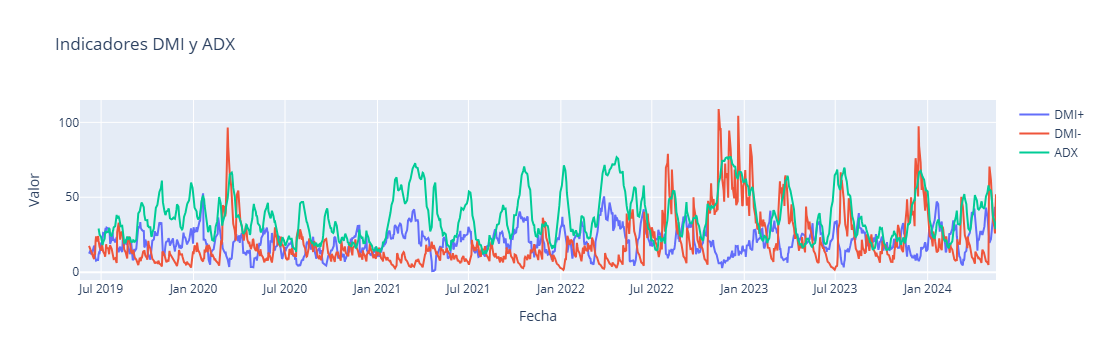

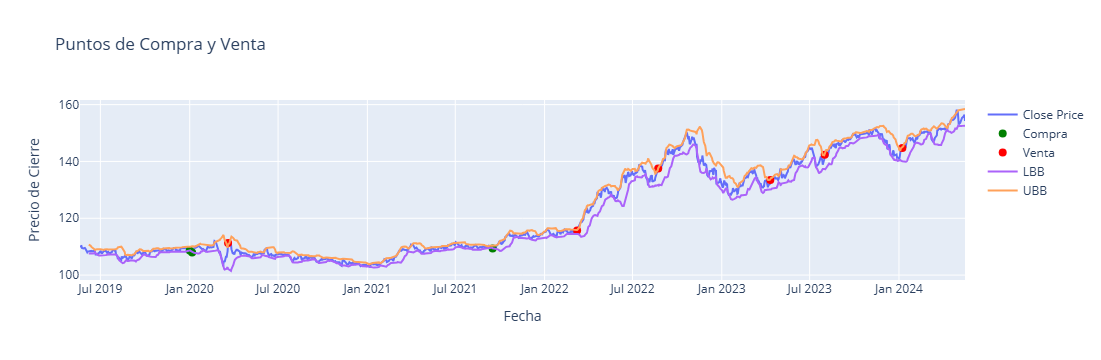

In [61]:
def plot_interactive_chart(data):
    # Creamos la figura
    fig = go.Figure()

    # Añadimos la serie de precios de cierre
    fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Close Price'))

    # Añadimos los puntos de compra y venta
    buy_points = data[data['Long_Position'] == 1]
    sell_points = data[data['Short_Position'] == 1]

    fig.add_trace(go.Scatter(x=buy_points.index, y=buy_points['Close'], mode='markers', name='Compra', marker=dict(color='green', size=8)))
    fig.add_trace(go.Scatter(x=sell_points.index, y=sell_points['Close'], mode='markers', name='Venta', marker=dict(color='red', size=8)))
    fig.add_trace(go.Scatter(x=data.index, y=data['LowerBand'], mode='lines', name='LBB'))
    fig.add_trace(go.Scatter(x=data.index, y=data['UpperBand'], mode='lines', name='UBB'))
    
    # Configuramos el diseño de la figura
    fig.update_layout(title='Puntos de Compra y Venta',
                      xaxis_title='Fecha',
                      yaxis_title='Precio de Cierre',
                      hovermode='x',
                      showlegend=True)

    # Mostramos la figura
    fig.show()
def plot_indicators(data):
    # Creamos la figura
    fig = go.Figure()

    
    

    # Añadimos los indicadores DMI y ADX
    fig.add_trace(go.Scatter(x=data.index, y=data['DMI+'], mode='lines', name='DMI+'))
    fig.add_trace(go.Scatter(x=data.index, y=data['DMI-'], mode='lines', name='DMI-'))
    fig.add_trace(go.Scatter(x=data.index, y=data['ADX'], mode='lines', name='ADX'))

    # Configuramos el diseño de la figura
    fig.update_layout(title='Indicadores DMI y ADX',
                      xaxis_title='Fecha',
                      yaxis_title='Valor',
                      hovermode='x',
                      showlegend=True)

    # Mostramos la figura
    fig.show()

# Llamamos a la función para generar la gráfica de indicadores
plot_indicators(datos_1d)
# Llamamos a la función para generar la gráfica interactiva
plot_interactive_chart(datos_1d)

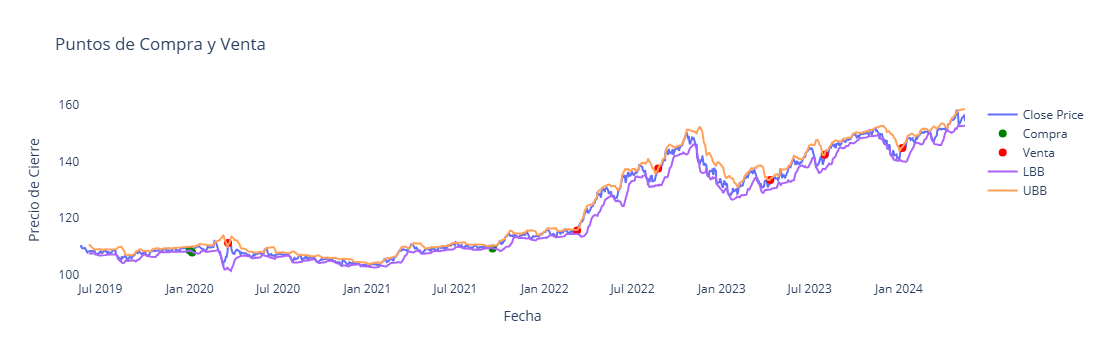

In [ ]:
import plotly.graph_objects as go

def plot_interactive_chart(data):
    # Creamos la figura
    fig = go.Figure()

    # Añadimos la serie de precios de cierre
    fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Close Price'))

    # Añadimos los puntos de compra y venta
    buy_points = data[data['Long_Position'] == 1]
    sell_points = data[data['Short_Position'] == 1]

    fig.add_trace(go.Scatter(x=buy_points.index, y=buy_points['Close'], mode='markers', name='Compra', marker=dict(color='green', size=8)))
    fig.add_trace(go.Scatter(x=sell_points.index, y=sell_points['Close'], mode='markers', name='Venta', marker=dict(color='red', size=8)))
    fig.add_trace(go.Scatter(x=data.index, y=data['LowerBand'], mode='lines', name='LBB'))
    fig.add_trace(go.Scatter(x=data.index, y=data['UpperBand'], mode='lines', name='UBB'))

    # Configuramos el diseño de la figura con fondo blanco
    fig.update_layout(
        title='Puntos de Compra y Venta',
        xaxis_title='Fecha',
        yaxis_title='Precio de Cierre',
        hovermode='x',
        showlegend=True,
        plot_bgcolor='white',  # Fondo del gráfico en blanco
        paper_bgcolor='white'  # Fondo del papel en blanco
    )

    # Mostramos la figura
    fig.show()

# Ejemplo de uso (data debe ser un DataFrame con las columnas mencionadas)
plot_interactive_chart(datos_1d)




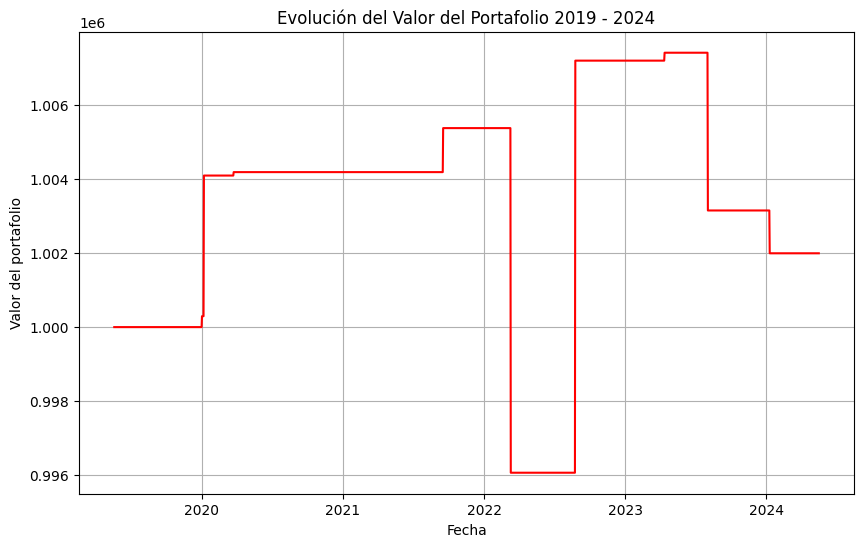

In [43]:
def graficar_valor_portafolio(data):
    if 'Worth' in data.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(data.index, data['Worth'], color='red', label='Valor del portafolio')
        plt.title('Evolución del Valor del Portafolio 2019 - 2024')
        plt.xlabel('Fecha')
        plt.ylabel('Valor del portafolio')
        plt.grid(True)
        plt.show()
    else:
        print("No se encontró la columna 'Worth' en el DataFrame de resultados.")
graficar_valor_portafolio(datos_1d)